<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
    <font color=orange>I - 2 </font>
  Sentence Classification
  </div> 

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. <font color=orange>**Sentence Classification**</font>

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. Sequence to sequence



### Part III

1. Abstractive Summarization

2. Question Answering

3. Chatbot


</div>

***

<a id="plan"></a>

| | | | | |
|------|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 

# Overview


The global structure of the [sentence classifier](#classifier) is the pipeline of three modules, followed by a final classification layer :



| | Module |  | |
|------|------|------|------|
| 1 | **Word Embedding** | [I.1 Custom model](#word_level_custom) | [I.2 Gensim Model](#gensim) | [I.3 FastText model](#fastText) |
| 2 | **Contextualization** | [II.1 bidirectionnal GRU](#bi_gru) |  |
| 3 | **Self-Attention** | [III.1 Self-Attention](#attention) | [III.2 Multi-head Self-Attention](#multihead_attention) |



All details on Word Embedding modules and their pre-training are found in **Part I - 1**.

# Packages

In [1]:
from __future__ import unicode_literals, print_function, division
import sys
import warnings
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import gc
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.5.0
DL device : cuda


In [2]:
path_to_DL4NLP = os.path.dirname(os.getcwd())

In [3]:
sys.path.append(path_to_DL4NLP + '\\lib')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.

In [4]:
df_AGnews_trn = pd.read_csv(path_to_DL4NLP + "\\data\\AG News\\train.csv", sep = ',', header = None, error_bad_lines = False)
df_AGnews_tst = pd.read_csv(path_to_DL4NLP + "\\data\\AG News\\test.csv" , sep = ',', header = None, error_bad_lines = False)

In [5]:
df_AGnews_trn.columns = ['index', 'title', 'description']
df_AGnews_tst.columns = ['index', 'title', 'description']

In [6]:
df_AGnews_trn.head()

,index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
def tokenize(s) :
    def unicodeToAscii(s):
        return ''.join( c for c in unicodedata.normalize('NFD', s)
                        if unicodedata.category(c) != 'Mn')

    def normalizeString(s):
        s = unicodeToAscii(s.strip())
        return s

    def cleanSentence(s) :
        s = s.lower()
        s = s.replace('\\', ' ')
        s = re.sub('[\.!?]+ ', ' . ', s)
        s = s.replace('%', ' % ')
        s = re.sub(' [0-9]*\.[0-9] ', ' FLOAT ', ' ' + s + ' ').strip()
        s = re.sub(' [0-9,]*[0-9] ', ' INT ', ' ' + s + ' ').strip()

        for w in ['"', "'", '”', '“', '/', '(', ')', '[', ']', '<', '>', ':', ','] : s = s.replace(w, '')
        return s

    def trueWord(w) :
        return len(w)>0 and re.sub('[^a-zA-Z0-9.,]', '', w) != ''

    s = normalizeString(s)
    s = cleanSentence(s)
    s = nltk.tokenize.word_tokenize(s)
    s = [w for w in s if trueWord(w)]
    return s

In [8]:
# reduce label by 1 to make is starts from 0
labelled_sentences_trn = [[tokenize(s1 + ' . ' + s2), l-1] for s1, s2, l in zip(df_AGnews_trn["title"].values.tolist(), df_AGnews_trn["description"].values.tolist(), df_AGnews_trn["index"].values.tolist()) if tokenize(s1) != []]
labelled_sentences_tst = [[tokenize(s1 + ' . ' + s2), l-1] for s1, s2, l in zip(df_AGnews_tst["title"].values.tolist(), df_AGnews_tst["description"].values.tolist(), df_AGnews_tst["index"].values.tolist()) if tokenize(s1) != []]

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

We assume that embedding model were pretrained following the steps detailed in **Part I - 1**.<br>
We consider here Word2Vec models pre-trained following the Skip-Gram training objective.

Since the chosen word embedding model must interact with subsequent modules int the sentence classification model, we wrap each model into a common small module that uniformize communication between any of these modules with subsequent ones.

To speed up training we want to pre-pack sentences into mini-batches, each mini-batch forming a single Torch Variable. There are two issues for this :<br> First, packing sentences into mini-batches needs to introduce a additionnal _padding_ word in the Word2Vc model, in order to put sentences of a single mini-batch at equal length. Second, the Word2Vc model must be able to handle Torch Variables, which is not the case for Gensim and FastText models.

A solution to these issues is to associate to the Word2Vec model a _twin_, which will be a Pytorch module containing and additionnal padding word/vector.


The strength of FastText is the possiblity to advocate a word vctor to most unseen word by taking embedding of subword units.<br> However this advantage no longer exists for the Pytorch twin, since in such model only the lookup table remains.<br> Therefore it is necessary to wrap the fastText model into another Pytorch model, which will use a twin of the model for fast training and then use the original Word2Vec model for inference.

All models are frozen after being loaded, so that none of their parameters is targeted by the sentence classifier optimizer.

In [9]:
#from libDL4NLP.models import Word2VecConnector

In [10]:
class Word2VecConnector(nn.Module) :
    '''A Pytorch module wrapping a FastText word2vec model'''
    def __init__(self, word2vec) :
        super().__init__()
        
        self.word2vec = word2vec
        self.twin = myWord2Vec(lang = Lang([list(word2vec.wv.index2word)], base_tokens = []), T = word2vec.wv.vectors)
        self.twin.addWord('PADDING_WORD')
        self.twin.addWord('UNK')
        self.twin = self.twin.freeze()
        
        self.lang      = self.twin.lang
        self.embedding = self.twin.embedding
        self.out_dim   = self.twin.out_dim
        
    def lookupTable(self) :
        return self.word2vec.wv.vectors
        
    def forward(self, words, device = None) :
        '''Transforms a sequence of n words into a Torch FloatTensor of size (1, n, emb_dim)'''
        try :
            embeddings = Variable(torch.Tensor(self.word2vec[words])).unsqueeze(0)
            if device is not None : embeddings = embeddings.to(device)
        except :
            embeddings = self.twin(words, device)
        return embeddings

<a id="word_level_custom"></a>


#### 1.1.1 Custom model

In [11]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.utils import Lang

In [12]:
# pretrained
#custom_word2vec = torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_I1_cbow.pt').freeze()

# from scratch
lang = Lang(corpus = [sl[0] for sl in labelled_sentences_trn], min_count = 5)
print(lang.n_words)

word2vec = myWord2Vec(lang, T = 100)

30465


<a id="gensim"></a>

#### 1.1.2 Gensim model

In [12]:
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile

In [14]:
# load
file_name = get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_I2_skipgram_gensim.model")
sg_gensim = Word2Vec.load(file_name)

In [15]:
sg_gensim = Word2Vec(
    [s[0] for s in labelled_sentences_trn],
    size      = 100, 
    window    = 5, 
    min_count = 5, 
    negative  = 20, 
    iter      = 25,
    sg        = 1,
    workers   = multiprocessing.cpu_count())

In [14]:
# save
#file_name = get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_I2_skipgram_gensim.model")
#sg_gensim.save(file_name)

In [17]:
gensim_word2vec = Word2VecConnector(sg_gensim)

<a id="fastText"></a>

#### 1.1.3 FastText model

In [13]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

In [14]:
# load
file_name = get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_I2_skipgram_fasttext.model")
sg_fasttext = Word2Vec.load(file_name)

In [ ]:
sg_fasttext = FastText(
    size      = 100, 
    window    = 5, 
    min_count = 5, 
    negative  = 20,
    sg        = 1)

sg_fasttext.build_vocab([s[0] for s in labelled_sentences_trn])

sg_fasttext.train(
    sentences = [s[0] for s in labelled_sentences_trn], 
    epochs = 25,
    total_examples = sg_fasttext.corpus_count)

In [ ]:
# save
#file_name = get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_I2_skipgram_fasttext.model")
#sg_fasttext.save(file_name)

In [15]:
fasttext_word2vec = Word2VecConnector(sg_fasttext)

### 1.2 Contextualization module

[Back to top](#plan)

The contextualization layer transforms a sequences of word vectors into another one, of same length, where each output vector corresponds to a new version of each input vector that is contextualized with respect to neighboring vectors.

<a id="bi_gru"></a>

#### 1.2.1 Bi-directionnal GRU contextualization

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [17]:
#from libDL4NLP.modules import RecurrentEncoder

In [16]:
class RecurrentEncoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, 
                 n_layer = 1, 
                 dropout = 0, 
                 bidirectional = False): 
        super().__init__()
        
        # relevant quantities
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.out_dim = hid_dim # * (2 if bidirectional else 1)
        self.n_layer = n_layer
        self.bidirectional = bidirectional

        # layers
        self.dropout = nn.Dropout(p = dropout)
        self.bigru = nn.GRU(
            emb_dim, 
            hid_dim, 
            n_layer,
            dropout = (0 if n_layer == 1 else dropout), 
            bidirectional = bidirectional,
            batch_first = False)

        
    def forward(self, embeddings, 
                lengths = None, 
                hidden = None, 
                enforce_sorted = True) :
        # embedding
        embeddings = self.dropout(embeddings)    # size (batch_size, input_length, emb_dim)
        embeddings = embeddings.transpose(0, 1)  # size (input_length, batch_size, emb_dim)
        # packing
        if lengths is not None : 
            embeddings = nn.utils.rnn.pack_padded_sequence(
                embeddings, 
                lengths, 
                batch_first = False, 
                enforce_sorted = enforce_sorted)
        # GRU pass
        outputs, hidden = self.bigru(embeddings, hidden)
        # padding
        if lengths is not None : 
            outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first = False)
        # Sum bidirectional GRU outputs
        if self.bidirectional : outputs = outputs[:, :, :self.hid_dim] + outputs[:, : ,self.hid_dim:]
        # batch first
        outputs = outputs.transpose(0, 1) # size (batch_size, input_length, out_dim)
        # dropout
        outputs = self.dropout(outputs) # size (batch_size, input_length, out_dim)
        hidden  = self.dropout(hidden)  # size (n_layer * num_dir, batch_size, hid_dim)
        return outputs, hidden

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

#### 1.3.1 Self-Attention Module with Highway connections

Highway connections are presented in [Highway Networks (2015)](https://arxiv.org/pdf/1505.00387.pdf)

In [19]:
#from libDL4NLP.modules import SelfAttention
#from libDL4NLP.misc    import Highway

In [17]:
class Highway(nn.Module):
    def __init__(self, dim, 
                 dropout = 0, 
                 act = F.tanh):
        super().__init__()
        
        # relevant quantities
        self.dim = dim
        
        # layers
        self.transf  = nn.Linear(dim, dim)
        self.gate    = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(p = dropout)
        self.act     = act

    def forward(self, vect):
        transf = self.act(self.transf(vect))
        gate   = F.sigmoid(self.gate(vect))
        vect   = gate * transf + (1 - gate) * vect
        vect   = self.dropout(vect)
        return vect

In [18]:
class SelfAttention(nn.Module):
    def __init__(self, emb_dim, 
                 dropout = 0): 
        super().__init__()

        # relevant quantities
        self.emb_dim = emb_dim
        self.out_dim = emb_dim

        # layers
        self.dropout = nn.Dropout(p = dropout)
        self.key     = nn.Sequential(Highway(emb_dim), nn.Linear(emb_dim, 1, bias = False))
        self.value   = Highway(emb_dim, dropout = dropout)
        self.act     = F.softmax
    
    def computeMask(self, lengths, max_length) :
        # see http://juditacs.github.io/2018/12/27/masked-attention.html
        return torch.arange(max_length).to(lengths.device)[None, :] < lengths[:, None]

    def forward(self, embeddings,
               lengths = None) :             # size (batch_size, max_length, emb_dim)  
        # compute weights
        weights = self.key(embeddings)       # size (batch_size, max_length, 1) 
        weights = weights.squeeze(2)         # size (batch_size, max_length)
        # mask attention over padded tokens
        if lengths is not None :
            mask = self.computeMask(lengths, weights.size(1))
            weights[~mask] = float('-inf')   # size (batch_size, max_length)
        # compute weighted sum
        weights = self.act(weights, dim = 1) # size (batch_size, max_length)
        weights = weights.unsqueeze(1)       # size (batch_size, 1, max_length)
        values  = self.value(embeddings)     # size (batch_size, max_length, emb_dim)
        applied = torch.bmm(weights, values) # size (batch_size, 1, emb_dim)
        return applied, weights

<a id="multihead_attention"></a>

#### 1.3.2 Multi-head Self-Attention Module

- Idea presented at ICLR 2017 : [A structured self-attentive sentence embedding (2017)](https://arxiv.org/pdf/1703.03130.pdf)
- Latest development : [Orthogonality Constrained Multi-Head Attention For Keyword Spotting (2019)](https://arxiv.org/pdf/1910.04500.pdf)

In [21]:
#from libDL4NLP.modules import MultiHeadSelfAttention

In [19]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_dim, 
                 n_head = 1, 
                 penalization = False, 
                 dropout = 0): 
        super().__init__()
        
        # relevant quantities
        self.emb_dim = emb_dim
        self.out_dim = n_head * emb_dim
        self.penalization = penalization
        self.n_head = n_head
        
        # layers
        self.attn_list = nn.ModuleList([SelfAttention(emb_dim, dropout) for i in range(n_head)])
        
    def compute_penalty(self, weights) :
        weights_t = weights.transpose(1, 2)
        def_pos   = [torch.mm(weights[i], weights_t[i]) for i in range(weights.size(0))] # size (batch_size, n_heads, n_heads)
        ide       = Variable(torch.eye(self.n_head)).to(weights.device)
        penal     = torch.sum(torch.cat([torch.norm(mmt - ide).view(1) for mmt in def_pos]))
        return penal
    
    def forward(self, embeddings, 
                lengths = None,
                compute_penalty = False):
        # compute self-attention
        outputs = [attn(embeddings, lengths) for attn in self.attn_list]
        applied = torch.cat([out[0] for out in outputs], dim = 1) # size (batch_size, n_heads, embedding_dim)
        weights = torch.cat([out[1] for out in outputs], dim = 1) # size (batch_size, n_heads, input_length)

        # compute penalty
        if self.penalization and compute_penalty and self.n_head > 1 :
            penal = self.compute_penalty(weights)
            return (applied, weights, penal)
        elif compute_penalty : 
            return (applied, weights, None)
        else :
            return (applied, weights)

### 1.4 Visualisation of attention

#### 1.4.1 Visualisation with heatmap

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [23]:
#from libDL4NLP.utils import AttentionViewer, AttentionViewerOnWords

In [20]:
def AttentionViewer(attention, row_labels, col_labels) : 
    '''attention  = np.array of size (num_rows, num_columns)
       row_labels = list of (str)
       col_labels = list of (str)
    '''
    def heatmap(data, row_labels, col_labels, ax = None, cbar_kw = {}, cbarlabel = "", **kwargs):
        if not ax: ax = plt.gca()
        # Plot the heatmap
        im = ax.imshow(data, **kwargs)
        # We want to show all ticks...
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_yticks(np.arange(data.shape[0]))
        # ... and label them with the respective list entries.
        ax.set_xticklabels(col_labels)
        ax.set_yticklabels(row_labels)
        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")
        # Turn spines off and create white grid.
        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        return im

    def annotate_heatmap(im, data = None, valfmt = "{x:.2f}", textcolors = ["black", "white"], threshold = None, **textkw):
        if not isinstance(data, (list, np.ndarray)):
            data = im.get_array()
        # Normalize the threshold to the images color range.
        if threshold is not None:
            threshold = im.norm(threshold)
        else:
            threshold = im.norm(data.max())/2.
        # Set default alignment to center, but allow it to be
        # overwritten by textkw.
        kw = dict(horizontalalignment = "center",
                  verticalalignment   = "center")
        kw.update(textkw)
        # Get the formatter in case a string is supplied
        if isinstance(valfmt, str):
            valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
        # Loop over the data and create a `Text` for each "pixel".
        # Change the text's color depending on the data.
        texts = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)
        return texts
    
    # -- main --
    fig, ax = plt.subplots()
    im      = heatmap(attention, row_labels, col_labels, ax=ax, cmap="YlGn", cbarlabel="harvest [t/year]")
    texts   = annotate_heatmap(im, valfmt="{x:.2f}")
    fig.tight_layout()
    plt.show()
    return

#### 1.4.2 Visualisation on processed tokens

In [21]:
def AttentionViewerOnWords(attention, row_labels, col_labels, 
                           colors = 'Reds', 
                           n = 8) : 
    '''attention  = np.array of size (num_rows, num_columns)
       row_labels = list of (str)
       col_labels = list of (str)
    '''
    def generateColors(colors, n):
        colors = plt.get_cmap(colors)
        Triplets = []
        for i in range(n) :
            triplet = [int(j * 256) for j in colors(i/10)[:3]]
            Triplets.append(triplet)
        return Triplets
    
    def weight2color(weight, triplets):
        n = len(triplets)
        for i in range(n):
            if weight >= i/n and weight <= (i+1)/n : 
                return triplets[i]
            
    def addColor(texte, 
                 RGB = (100,100,100)):
        new_texte = '\x1b[48;2;'  + str(RGB[0]) + ";" + str(RGB[1]) + ";" + str(RGB[2]) + "m"  + texte + "\x1b[0m"
        return new_texte
    
    # -- main --
    Triplets = generateColors(colors, n)
    Colored_text = ''
    sep = ' - ' if attention.shape[0] > 1 else ''
    for i in range(attention.shape[0]) :
        #Colored_text += row_labels[i] + sep
        for j in range(attention.shape[1]) :
            color = weight2color(attention[i, j], Triplets)
            Colored_text += addColor(col_labels[j], color) + ' '
        Colored_text += sep + row_labels[i] + '\n' 
    print(Colored_text)
    return

<a id="model"></a>

# 2 Sentence Classifier

[Back to top](#plan)


### Model

In [26]:
#from libDL4NLP.models import SentenceClassifier

In [22]:
class SentenceClassifier(nn.Module) :
    def __init__(self, device, tokenizer, word2vec, 
                 hidden_dim = 100, 
                 n_layer = 1, 
                 n_head  = 1, 
                 attn_penalization = False,
                 n_class = 2, 
                 dropout = 0, 
                 class_weights = None, 
                 optimizer = optim.SGD
                 ):
        super().__init__()
        
        # relevant quantities
        self.bin_mode  = (n_class == 'binary')
        self.opc       = (n_head == 'opc' and n_class != 'binary')
        
        # layers
        self.tokenize  = tokenizer
        self.word2vec  = word2vec
        self.context   = RecurrentEncoder(
            emb_dim = self.word2vec.out_dim,
            hid_dim = hidden_dim, 
            n_layer = n_layer, 
            dropout = dropout, 
            bidirectional = True)
        self.attention = MultiHeadSelfAttention(
            emb_dim      = self.context.out_dim, 
            n_head       = (n_class if self.opc else n_head),
            penalization = attn_penalization, 
            dropout      = dropout)
        self.out = nn.Linear(
            (self.context.out_dim if self.opc else self.attention.out_dim), 
            (1 if self.opc or self.bin_mode else n_class))
        self.act = F.sigmoid if self.bin_mode else F.softmax
        
        # optimizer
        if self.bin_mode : self.criterion = nn.BCEWithLogitsLoss(size_average = False)
        else             : self.criterion = nn.NLLLoss(size_average = False, weight = (torch.Tensor(class_weights) if class_weights is not None else None))
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    
    # main method
    def forward(self, sentence, attention_method = None) :
        '''classifies a sentence as string'''
        words      = self.tokenize(sentence)
        embeddings = self.word2vec(words, self.device)
        hiddens, _ = self.context(embeddings) 
        out, attn  = self.attention(hiddens)
        attn       = np.array(attn[0].data.cpu().numpy()) # size (n_heads, input_length)
        # compute prediction
        if self.opc : 
            out    = self.out(out).squeeze(2) # size (1, n_class)
            out    = self.act(out, dim = 1)   # size (1, n_class)
            labels = ['class '+str(i+1) for i in range(attn.shape[0])] if attn.shape[0] > 1 else ['']
            pred   = out.data.topk(1)[1].item()
        elif self.bin_mode : 
            out    = out.view(1, -1) # size (1, n_heads * embedding_dim)
            out    = self.out(out)   # size (1, 1)
            labels = ['head '+str(i+1) for i in range(attn.shape[0])] if attn.shape[0] > 1 else ['']
            pred   = out.item()
        else :
            out    = out.view(1, -1)         # size (1, n_heads * embedding_dim)
            out    = self.act(self.out(out)) # size (1, n_class)
            labels = ['head '+str(i+1) for i in range(attn.shape[0])] if attn.shape[0] > 1 else ['']
            pred   = out.data.topk(1)[1].item()
        # show attention
        if attention_method is not None : attention_method(attn, labels, words)
        return pred
    
    
    # load data
    def generatePackedSentences(self, sentences, batch_size = 32) :
        def sentence2indices(words) :
            inds  = [self.word2vec.lang.getIndex(w) for w in words]
            inds  = [i for i in inds if i is not None]
            return inds
        
        # --- main ---
        sentences.sort(key = lambda s: len(s[0]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            pack = [[sentence2indices(s[0]), s[1]] for s in sentences[i:i + batch_size]]
            pack.sort(key = lambda s : len(s[0]), reverse = True)
            pack0 = [p[0] for p in pack]
            lengths = torch.tensor([len(p) for p in pack0])               # size (batch_size) 
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.word2vec.lang.getIndex('PADDING_WORD')))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1))     # size (batch_size, max_length)
            pack1 = [p[1] for p in pack]
            if self.bin_mode : pack1 = Variable(torch.FloatTensor(pack1)) # size (batch_size) 
            else             : pack1 = Variable(torch.LongTensor(pack1))  # size (batch_size) 
            packed_data.append([[pack0, lengths], pack1])
        return packed_data
    
    
    # compute model perf
    def compute_accuracy(self, sentences, batch_size = 32) :
        def compute_batch_accuracy(batch, target) :
            torch.cuda.empty_cache()
            batch_size  = batch[0].size(0)
            lengths     = batch[1].to(self.device)
            embeddings  = self.word2vec.embedding(batch[0].to(self.device))
            hiddens, _  = self.context(embeddings, lengths)
            out, attn   = self.attention(hiddens, lengths) # size (batch_size, n_heads, embedding_dim)
            # compute score
            if self.opc : 
                vect   = self.out(out).squeeze(2)        # size (batch_size, n_class)
                log_ps = F.log_softmax(vect, dim = 1)    # size (batch_size, n_class)
                target = target.to(self.device).view(-1) # size (batch_size)
                score  = sum([target[i].item() == log_ps[i].data.topk(1)[1].item() for i in range(target.size(0))])
            elif self.bin_mode : 
                vect   = out.view(batch_size, -1)        # size (batch_size, n_heads * embedding_dim)
                vect   = self.out(vect).view(-1)         # size (batch_size)
                target = target.to(self.device).view(-1)
                score  = sum(torch.abs(target - self.act(vect)) < 0.5).item()
            else :
                vect   = out.view(batch_size, -1)        # size (batch_size, n_heads * embedding_dim)
                vect   = self.out(vect)                  # size (batch_size, n_class)
                log_ps = F.log_softmax(vect, dim = 1)    # size (batch_size, n_class)
                target = target.to(self.device).view(-1) # size (batch_size)
                score  = sum([target[i].item() == log_ps[i].data.topk(1)[1].item() for i in range(target.size(0))])
            return score
            
        # --- main ---
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch, target in batches : score += compute_batch_accuracy(batch, target)
        return score * 100 / len(sentences)
    
    
    # fit model
    def fit(self, batches, iters = None, epochs = None, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeLogProbs(batch) :
            batch_size = batch[0].size(0)
            lengths    = batch[1].to(self.device)
            embeddings = self.word2vec.embedding(batch[0].to(self.device))
            hiddens, _ = self.context(embeddings, lengths)
            out, attn, penal = self.attention(hiddens, lengths, compute_penalty = True) # size (batch_size, n_heads, embedding_dim)
            # compute log probs
            if self.opc : 
                vect   = self.out(out).squeeze(2)      # size (batch_size, n_class)
                log_ps = F.log_softmax(vect, dim = 1)  # size (batch_size, n_class)
            elif self.bin_mode : 
                vect   = out.view(batch_size, -1)      # size (batch_size, n_heads * emb_dim)
                log_ps = self.out(vect).view(-1)       # size (batch_size)
            else :
                vect   = out.view(batch_size, -1)      # size (batch_size, n_heads * emb_dim)
                vect   = self.out(vect)                # size (batch_size, n_class)
                log_ps = F.log_softmax(vect, dim = 1)  # size (batch_size, n_class)
            return log_ps, penal

        def computeAccuracy(log_probs, targets) :
            if self.bin_mode : return sum(torch.abs(targets - self.act(log_probs)) < 0.5).item() * 100 / targets.size(0)
            else             : return sum([targets[i].item() == log_probs[i].data.topk(1)[1].item() for i in range(targets.size(0))]) * 100 / targets.size(0)
            
        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update."""
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            self.zero_grad()
            log_probs, penal = computeLogProbs(batch[0])
            targets = batch[1].to(self.device).view(-1)
            loss    = self.criterion(log_probs, targets)
            if penal is not None and penal.item() > 1 : loss = loss + penal * 0.01
            loss.backward()
            optimizer.step() 
            accuracy = computeAccuracy(log_probs, targets) if compute_accuracy else 0
            return float(loss.item() / targets.size(0)), accuracy
        
        # --- main ---
        self.train()
        random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

### Training

In [24]:
classifier = SentenceClassifier(device = device,
                                tokenizer = tokenize,
                                word2vec = Word2VecConnector(sg_gensim),
                                hidden_dim = 100, 
                                n_layer = 2,
                                n_head  = 2, # 'opc', #1,
                                attn_penalization = False,
                                n_class = 4, #'binary', 
                                dropout = 0.15,
                                optimizer = optim.AdamW)

classifier.nbParametres()

384204

In [75]:
batches = classifier.generatePackedSentences(labelled_sentences_trn, batch_size = 16)

In [76]:
len(batches)

7500

In [90]:
classifier.train()
classifier.fit(batches, epochs = 1, lr = 0.001, print_every = 100)
classifier.fit(batches, epochs = 1, lr = 0.0001, print_every = 100)
classifier.fit(batches, epochs = 1, lr = 0.00005, print_every = 100)

# start word2vec finetuning
classifier.word2vec = classifier.word2vec.twin.unfreeze()

classifier.fit(batches, epochs = 1, lr = 0.00005, print_every = 100)

epoch 1
0m 9s (- 12m 10s) (100 1%) loss : 0.662  accuracy : 73.3 %
0m 19s (- 11m 34s) (200 2%) loss : 0.402  accuracy : 85.4 %
0m 28s (- 11m 23s) (300 4%) loss : 0.399  accuracy : 86.8 %
0m 37s (- 11m 5s) (400 5%) loss : 0.323  accuracy : 89.4 %
0m 46s (- 10m 44s) (500 6%) loss : 0.419  accuracy : 85.9 %
0m 54s (- 10m 30s) (600 8%) loss : 0.372  accuracy : 87.4 %
1m 3s (- 10m 17s) (700 9%) loss : 0.309  accuracy : 89.3 %
1m 12s (- 10m 5s) (800 10%) loss : 0.339  accuracy : 89.6 %
1m 21s (- 9m 54s) (900 12%) loss : 0.299  accuracy : 89.9 %
1m 29s (- 9m 43s) (1000 13%) loss : 0.296  accuracy : 89.9 %
1m 38s (- 9m 33s) (1100 14%) loss : 0.369  accuracy : 87.2 %
1m 47s (- 9m 23s) (1200 16%) loss : 0.327  accuracy : 88.1 %
1m 56s (- 9m 13s) (1300 17%) loss : 0.314  accuracy : 89.3 %
2m 4s (- 9m 3s) (1400 18%) loss : 0.318  accuracy : 89.1 %
2m 13s (- 8m 54s) (1500 20%) loss : 0.334  accuracy : 88.2 %
2m 22s (- 8m 45s) (1600 21%) loss : 0.273  accuracy : 90.8 %
2m 31s (- 8m 36s) (1700 22%) l

6m 41s (- 1m 24s) (6200 82%) loss : 0.223  accuracy : 91.6 %
6m 48s (- 1m 17s) (6300 84%) loss : 0.203  accuracy : 92.9 %
6m 54s (- 1m 11s) (6400 85%) loss : 0.228  accuracy : 91.2 %
7m 0s (- 1m 4s) (6500 86%) loss : 0.226  accuracy : 91.6 %
7m 6s (- 0m 58s) (6600 88%) loss : 0.196  accuracy : 93.2 %
7m 13s (- 0m 51s) (6700 89%) loss : 0.185  accuracy : 93.9 %
7m 19s (- 0m 45s) (6800 90%) loss : 0.243  accuracy : 91.6 %
7m 25s (- 0m 38s) (6900 92%) loss : 0.226  accuracy : 92.1 %
7m 31s (- 0m 32s) (7000 93%) loss : 0.198  accuracy : 92.7 %
7m 37s (- 0m 25s) (7100 94%) loss : 0.233  accuracy : 91.6 %
7m 43s (- 0m 19s) (7200 96%) loss : 0.252  accuracy : 90.9 %
7m 50s (- 0m 12s) (7300 97%) loss : 0.222  accuracy : 91.7 %
7m 56s (- 0m 6s) (7400 98%) loss : 0.216  accuracy : 92.7 %
8m 2s (- 0m 0s) (7500 100%) loss : 0.228  accuracy : 92.0 %
epoch 1
0m 6s (- 7m 54s) (100 1%) loss : 0.211  accuracy : 92.4 %
0m 12s (- 7m 40s) (200 2%) loss : 0.224  accuracy : 91.8 %
0m 18s (- 7m 34s) (300 4%)

6m 47s (- 3m 48s) (4800 64%) loss : 0.184  accuracy : 93.4 %
6m 55s (- 3m 40s) (4900 65%) loss : 0.199  accuracy : 92.9 %
7m 4s (- 3m 32s) (5000 66%) loss : 0.185  accuracy : 93.2 %
7m 12s (- 3m 23s) (5100 68%) loss : 0.179  accuracy : 93.4 %
7m 20s (- 3m 14s) (5200 69%) loss : 0.154  accuracy : 94.7 %
7m 29s (- 3m 6s) (5300 70%) loss : 0.205  accuracy : 93.1 %
7m 37s (- 2m 58s) (5400 72%) loss : 0.198  accuracy : 93.5 %
7m 46s (- 2m 49s) (5500 73%) loss : 0.225  accuracy : 91.8 %
7m 55s (- 2m 41s) (5600 74%) loss : 0.212  accuracy : 92.4 %
8m 4s (- 2m 32s) (5700 76%) loss : 0.205  accuracy : 92.9 %
8m 12s (- 2m 24s) (5800 77%) loss : 0.198  accuracy : 93.1 %
8m 21s (- 2m 15s) (5900 78%) loss : 0.197  accuracy : 92.9 %
8m 29s (- 2m 7s) (6000 80%) loss : 0.191  accuracy : 93.5 %
8m 37s (- 1m 58s) (6100 81%) loss : 0.216  accuracy : 92.5 %
8m 45s (- 1m 50s) (6200 82%) loss : 0.209  accuracy : 92.8 %
8m 54s (- 1m 41s) (6300 84%) loss : 0.203  accuracy : 92.8 %
9m 2s (- 1m 33s) (6400 85%) 

In [93]:
# save
#torch.save(classifier.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_I2_sentence_classifier.pth')

# load
#classifier.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_I2_sentence_classifier.pth'))

#### Evaluation single-head

In [42]:
sentence = 'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'
sentence

'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'

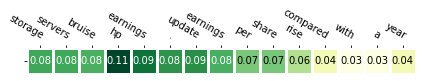

storage servers bruise hp earnings . update earnings per share rise compared with a year 



3

In [39]:
# attention heads = 1
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [40]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst)

92.46052631578948

#### Evaluation multi-head without penalization

In [42]:
sentence = 'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'
sentence

'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'

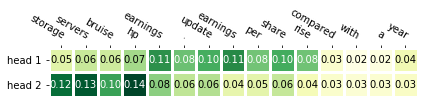

storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 1
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 2



3

In [91]:
# attention heads = 2
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [92]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst, batch_size = 16)

92.53947368421052

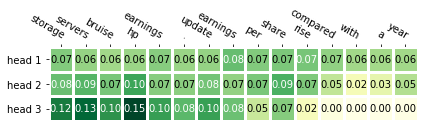

storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 1
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 2
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 3



3

In [136]:
# attention heads = 3
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [137]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst, batch_size = 16)

92.73684210526316

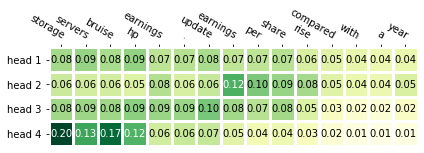

storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 1
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 2
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 3
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 4



3

In [31]:
# attention heads = 3
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [32]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst, batch_size = 16)

92.76315789473684

#### Evaluation multi-head with penalization

In [82]:
sentence = 'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'
sentence

'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'

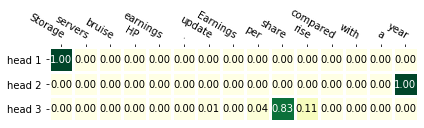

Storage servers bruise HP earnings . update Earnings per share rise compared with a year  - head 1
Storage servers bruise HP earnings . update Earnings per share rise compared with a year  - head 2
Storage servers bruise HP earnings . update Earnings per share rise compared with a year  - head 3



3

In [83]:
# attention heads = 3
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

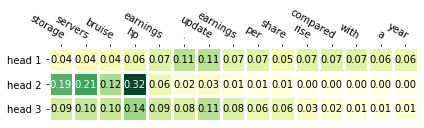

storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 1
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 2
storage servers bruise hp earnings . update earnings per share rise compared with a year  - head 3



3

In [35]:
# attention heads = 3, penal * 0.01
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [36]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst, batch_size = 16)

92.47368421052632

#### Evaluation one head per class

In [26]:
sentence = 'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'
sentence

'Storage servers bruise HP earnings . update Earnings per share rise compared with a year'

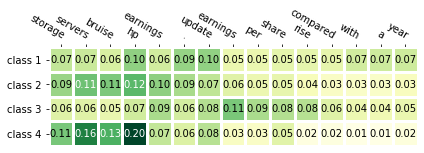

storage servers bruise hp earnings . update earnings per share rise compared with a year  - class 1
storage servers bruise hp earnings . update earnings per share rise compared with a year  - class 2
storage servers bruise hp earnings . update earnings per share rise compared with a year  - class 3
storage servers bruise hp earnings . update earnings per share rise compared with a year  - class 4



3

In [27]:
classifier.eval()
classifier(sentence, attention_method = AttentionViewer)
classifier(sentence, attention_method = AttentionViewerOnWords)

In [28]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences_tst, batch_size = 16)

92.25